# 导入函数库

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds # 这个是指Tensorflow Datasets
import matplotlib.pyplot as plt

# 如果出现显存不够的错误,把这个代码加上

In [2]:
# 加入下面这个代码片段主要是因为TF2.0对RTX20系列显卡支持不是很好,容易爆显存,所以设置成用多少占多少显存,而不是一次性全占了(默认)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 定义网络结构

## 一些参数设置

In [3]:
layers = tf.keras.layers
models = tf.keras.models

IMG_SIZE = 32
BATCH_SIZE = 8 * 1
SHUFFLE_BUFFER_SIZE = 48 * 1
DATASET_NAME = 'rock_paper_scissors'
SPLIT = ['test', 'train']
DATA_DIR = './tensorflow_datasets'
LEARNING_RATE = 1e-4
EPOCHS = 30
CLASSES = 3

## 定义LeNet5用于手势识别

In [4]:
def LeNet5(input_shape=(IMG_SIZE, IMG_SIZE, 3), # 原始图片是300x300x3
           classes=CLASSES):
    img_input = layers.Input(shape=input_shape)  # 输入节点

    x = layers.Conv2D(64, (5, 5),
                      activation='relu',
                      padding='valid',
                      name='conv1')(img_input)
    x = layers.BatchNormalization()(x)
    x = layers.AveragePooling2D()(x)
    x = layers.Conv2D(64, (5, 5),
                      activation='relu',
                      padding='valid',
                      name='conv2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.AveragePooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', name='fc2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input  # inputs是输入节点
    outputs = x  # outputs是输出节点
    model = models.Model(inputs, outputs, name='lenet5')  # 生成一个Model, 需要指定输入和输出

    return model

## 声明一个LeNet5模型实例

In [5]:
model = LeNet5()

In [6]:
model.summary()

Model: "lenet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 10, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 64)          0    

## 记录模型训练过程中的日志

In [7]:
log_dir = './logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## 进行数据增强

In [8]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image, label

def augment(image, label):
    image, label = convert(image, label)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.3) # Random brightness
    return image, label

## 数据读取并预处理

In [9]:
# 此处使用tfds的方式构建data pipeline
(raw_test, raw_train), metadata = tfds.load(
    DATASET_NAME, # 数据集名称，这个是手势识别分类数据集，共3个类别
    split=SPLIT, # 这里的raw_test和split的'test'对应，raw_train和split的'train'对应
    with_info=True, # 这个参数和metadata对应
    as_supervised=True, # 这个参数的作用是返回tuple形式的(input, label),举个例子，raw_test=tuple(input, label)
    data_dir=DATA_DIR
)

# 可以体验下这里是否加prefetch(tf.data.experimental.AUTOTUNE)和cache()的区别，对训练速度，以及CPU负载有影响
train_batches = raw_train.shuffle(SHUFFLE_BUFFER_SIZE).map(augment).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = raw_test.map(convert).batch(BATCH_SIZE)

## 进行模型训练

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.fit(
    train_batches,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback]
)

Epoch 1/30
315/315 [==============================] - 2s 5ms/step - loss: 0.7438 - accuracy: 0.8214
Epoch 2/30
315/315 [==============================] - 1s 5ms/step - loss: 0.6219 - accuracy: 0.9425
Epoch 3/30
315/315 [==============================] - 2s 5ms/step - loss: 0.6026 - accuracy: 0.9595
Epoch 4/30
315/315 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.9623
Epoch 5/30
315/315 [==============================] - 1s 5ms/step - loss: 0.5848 - accuracy: 0.9726
Epoch 6/30
315/315 [==============================] - 1s 5ms/step - loss: 0.5813 - accuracy: 0.9782
Epoch 7/30
315/315 [==============================] - 1s 5ms/step - loss: 0.5790 - accuracy: 0.9802
Epoch 8/30
315/315 [==============================] - 1s 4ms/step - loss: 0.5758 - accuracy: 0.9798
Epoch 9/30
315/315 [==============================] - 1s 4ms/step - loss: 0.5741 - accuracy: 0.9813
Epoch 10/30
315/315 [==============================] - 1s 4ms/step - loss: 0.5755 - accuracy: 0.9790

## 训练后的模型预测展示

scissors
paper
scissors
rock
rock


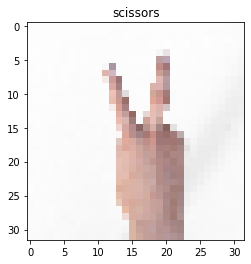

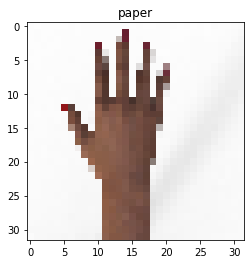

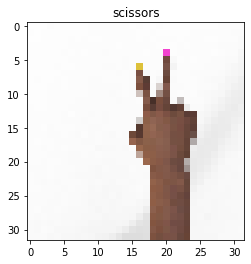

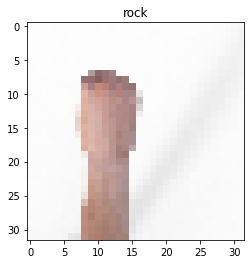

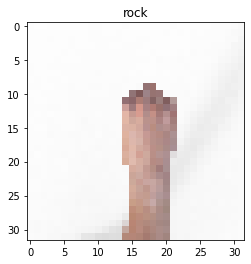

In [11]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_test.take(5):
    image, label = convert(image, label)
    predict = np.argmax(model.predict(np.expand_dims(image, axis=0)))
    print(get_label_name(predict))
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

## Baseline的test acc,并保存模型

In [12]:
_, baseline_model_accuracy = model.evaluate(test_batches, verbose=1)
print('Baseline test accuracy: ', baseline_model_accuracy)

keras_file = './test.h5'
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to: ', keras_file)

47/47 [==============================] - 0s 5ms/step - loss: 0.7541 - accuracy: 0.7742
Baseline test accuracy:  0.774193525314331
Saved baseline model to:  ./test.h5
